## Lesson 2 - deployment

Note that I did not create any notes for lesson 1, that lesson was just "getting started" and primarily a demonstration.

For this lesson, Jeremy starts by going through the first part of the book [chapter 2](https://github.com/fastai/fastbook/blob/master/02_production.ipynb) notebook to illustrate Fastai's data cleaning capabilities.  He trains a model to recognize grizzle, black and teddy bear from images, and then looks at the cases with the highest loss (which are either confidently wrong or not confidently right) and shows how the trained model helps to quickly find problems in the data.  Fastai also has a convenience tool ImageClassifierCleaner that shows the highest loss images with ipywidgets to select correct class or to delete. Pretty cool!

### Notes on going through notebook 2024:

- On google colab, fastbook.setup_book() errors out at the end "Credential propagation unsuccessful", but this didnt cause any problems

- The video uses Duck duck go, which requires using `search_images_ddg` instead of `search_images_bing`, and no key argument is required:
```{python}
results = search_images_ddg( 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)
```

The return type from `search_images_ddg` must be different, i had to change the call to `download_images` to be like this:

```{python}
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        #download_images(dest, urls=results.attrgot('contentUrl'))
        download_images(dest, urls = results)
```

## Training a model (for use in deployment)

In [1]:
import torch
# check for CUDA
if torch.cuda.is_available():
    print('CUDA is available')
else:
    print('CUDA is not available')


CUDA is not available


In [2]:
from fastai.vision.all import *

In [3]:
def is_cat(x): return x[0].isupper()


In [4]:
path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(192))


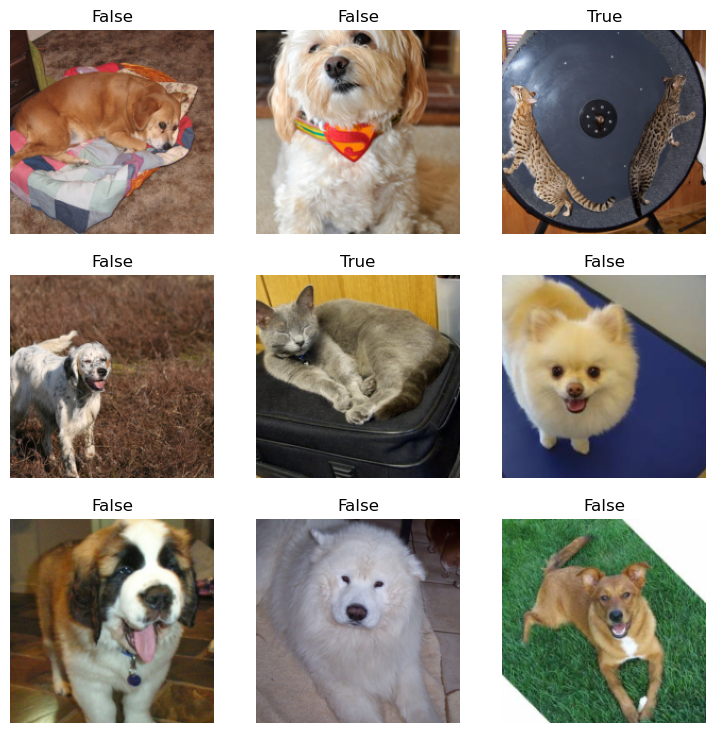

In [5]:
dls.show_batch()

Note that this would be much faster with GPU or on google collab.  For comparison (obviously not scientific):

* home pc using cpu , total time: 12m
* On collab using T4 gpu: 2m53s
* home pc using gpu: 37s.

 Here we are using a pretrained model.

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.198308,0.057525,0.017591,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.064781,0.063679,0.017591,00:09
1,0.044741,0.030266,0.010825,00:09
2,0.022283,0.023940,0.008796,00:09


In [7]:
learn.export('model.pkl')

## Notes on deployment

Course video recommend this [Tutorial](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html) but sadly it is out of date, for example the gr.inputs no longer exists, and you just use gr.Image, and further this class has changed and you no longer use `shape` but rather set the width and height seperately.   

In [2]:
from fastai.vision.all import *

def is_cat(x): return x[0].isupper()

learn = load_learner('model.pkl')


In [3]:

# define prediction model   

def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {'Cat': float(probs[1]), 'Noncat' : float(probs[0])}

In [11]:
predict('images/cat.jpg')

{'Cat': 1.0, 'Noncat': 3.014154204006303e-11}

In [4]:
import gradio as gr

In [6]:
demo = gr.Interface(fn=predict,
                     inputs=gr.Image(height= 512, width =512), 
                     outputs=gr.Label(num_top_classes=2), 
                     title = "Is it a cat?")


In [7]:
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [8]:
demo.close()

Closing server running on port: 7860


Next step is to host this on huggingface spaces. This is done by creating a space, cloning the repo they make for you and:

* add app.py

* add requirements.txt with single line `fastai`.  Should probably specify a version, but I did not.

* add model.pkl, but first make sure you use lfs for this.     I had to do `sudo apt-get install git-lfs` and then `git lfs install`.  This is followed by `git lfs track model.pkl` and then add all the changes.   (Of course i didn't discover this until I had already added the model, so i had to reset the repo and redo it. )

Final demo is here:
https://huggingface.co/spaces/DrEntropy/catTest